In [3]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

c:\Users\User\Documents\Code\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('data/clean/clean_dataset.csv')
df = df[['name', 'name_length']]
df.head()

,name,name_length
0,Gamis Pria Dewasa Premium / Jubah Pakistan Polos,38
1,Buket Bunga Mawar Flanel / Bunga wisuda / Bung...,11
2,Mika Sen Depan Supra Fit New Kaca Lampu Sein D...,10
3,Blazer wanita jumbo big size stik balik / plus...,24
4,Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...,69


In [6]:
# load POS taggers model
pos_custom_id = SequenceTagger.load('resources/taggers/stacked-upos/best-model.pt')
pos_custom_multi = SequenceTagger.load('resources/taggers/stacked-upos-en/best-model.pt')
pos_multiCorpus = SequenceTagger.load('resources/taggers/multiCorpus-upos/best-model.pt')
pos_bert_id = SequenceTagger.load('resources/taggers/bert-id-upos/best-model.pt')
pos_bert_multi = SequenceTagger.load('resources/taggers/bert-multi-upos/best-model.pt')

# extract nouns from text
def extract_noun_custom(text, tag_pos):
    try:
        tokens = re.split(r'[^\w]+', text.lower())
        cleaned_text = ' '.join(filter(None, tokens))
        
        sentence = Sentence(cleaned_text)
        tag_pos.predict(sentence)

        filtered_words = []
        seen = set()
        for token in sentence:
            if token.get_label('upos').value in ['NOUN'] and token.text not in seen:
                filtered_words.append(token.text)
                seen.add(token.text)
        return ' '.join(filtered_words)
    except Exception as e:
        print(f"Error processing text: {text}. Exception: {e}")
        return ''

# apply POS taggers to extract nouns
df['custom_id_noun'] = df['name'].apply(lambda text: extract_noun_custom(text, pos_custom_id))
df['custom_multi_noun'] = df['name'].apply(lambda text: extract_noun_custom(text, pos_custom_multi))
df['multiCorpus_noun'] = df['name'].apply(lambda text: extract_noun_custom(text, pos_multiCorpus))
df['bert_id_noun'] = df['name'].apply(lambda text: extract_noun_custom(text, pos_bert_id))
df['bert_multi_noun'] = df['name'].apply(lambda text: extract_noun_custom(text, pos_bert_multi))

2024-12-26 12:56:41,351 SequenceTagger predicts: Dictionary with 19 tags: NOUN, PROPN, PUNCT, VERB, ADP, PRON, ADJ, NUM, DET, CCONJ, ADV, AUX, SCONJ, PART, SYM, X, INTJ, <START>, <STOP>
2024-12-26 12:56:49,058 SequenceTagger predicts: Dictionary with 19 tags: NOUN, PROPN, PUNCT, VERB, ADP, PRON, ADJ, NUM, DET, CCONJ, ADV, AUX, SCONJ, PART, SYM, X, INTJ, <START>, <STOP>
2024-12-26 12:56:53,640 SequenceTagger predicts: Dictionary with 19 tags: NOUN, PROPN, PUNCT, VERB, ADP, PRON, ADJ, NUM, DET, CCONJ, ADV, AUX, SCONJ, PART, SYM, X, INTJ, <START>, <STOP>
2024-12-26 12:56:57,400 SequenceTagger predicts: Dictionary with 19 tags: NOUN, PROPN, PUNCT, VERB, ADP, PRON, ADJ, NUM, DET, CCONJ, ADV, AUX, SCONJ, PART, SYM, X, INTJ, <START>, <STOP>
2024-12-26 12:57:01,144 SequenceTagger predicts: Dictionary with 19 tags: NOUN, PROPN, PUNCT, VERB, ADP, PRON, ADJ, NUM, DET, CCONJ, ADV, AUX, SCONJ, PART, SYM, X, INTJ, <START>, <STOP>


c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [9]:
# List min_df dan range klaster
min_list = [5, 10, 20, 30, 40, 50]
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
results = []  # List untuk menyimpan hasil eksperimen

In [10]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(df, min_list, range_list):
    print(f"Evaluating min_df={min_df}...")

    for min_df in min_list:
        # TF-IDF Vectorization
        vectorizers = {
            'fastText_id': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['custom_id_noun']),
            'fastText_multi': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['custom_multi_noun']),
            'bert_id_v1': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['multiCorpus_noun']),
            'bert_id_v2': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['bert_id_noun']),
            'bert_multi': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['bert_multi_noun'])
        }

        for name, data in vectorizers.items():
            for cluster_range in range_list:
                silhouette_scores = []
                for n_clusters in cluster_range:
                    # K-Means clustering
                    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                    labels = kmeans.fit_predict(data)
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                
                # Simpan hasil eksperimen
                avg_score = sum(silhouette_scores) / len(silhouette_scores)
                results.append({
                    'model_noun': name,
                    'min_df': min_df,
                    'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                    'avg_silhouette_score': avg_score
                })

# Jalankan eksperimen
clustering_experiment(df, min_list, range_list)

Evaluating fastText_id with min_df=5...
Evaluating fastText_multi with min_df=5...
Evaluating bert_id_v1 with min_df=5...
Evaluating bert_id_v2 with min_df=5...
Evaluating bert_multi with min_df=5...
Evaluating fastText_id with min_df=10...
Evaluating fastText_multi with min_df=10...
Evaluating bert_id_v1 with min_df=10...
Evaluating bert_id_v2 with min_df=10...
Evaluating bert_multi with min_df=10...
Evaluating fastText_id with min_df=20...
Evaluating fastText_multi with min_df=20...
Evaluating bert_id_v1 with min_df=20...
Evaluating bert_id_v2 with min_df=20...
Evaluating bert_multi with min_df=20...
Evaluating fastText_id with min_df=30...
Evaluating fastText_multi with min_df=30...
Evaluating bert_id_v1 with min_df=30...
Evaluating bert_id_v2 with min_df=30...
Evaluating bert_multi with min_df=30...
Evaluating fastText_id with min_df=40...
Evaluating fastText_multi with min_df=40...
Evaluating bert_id_v1 with min_df=40...
Evaluating bert_id_v2 with min_df=40...
Evaluating bert_mult

In [22]:
results_df = pd.DataFrame(results)

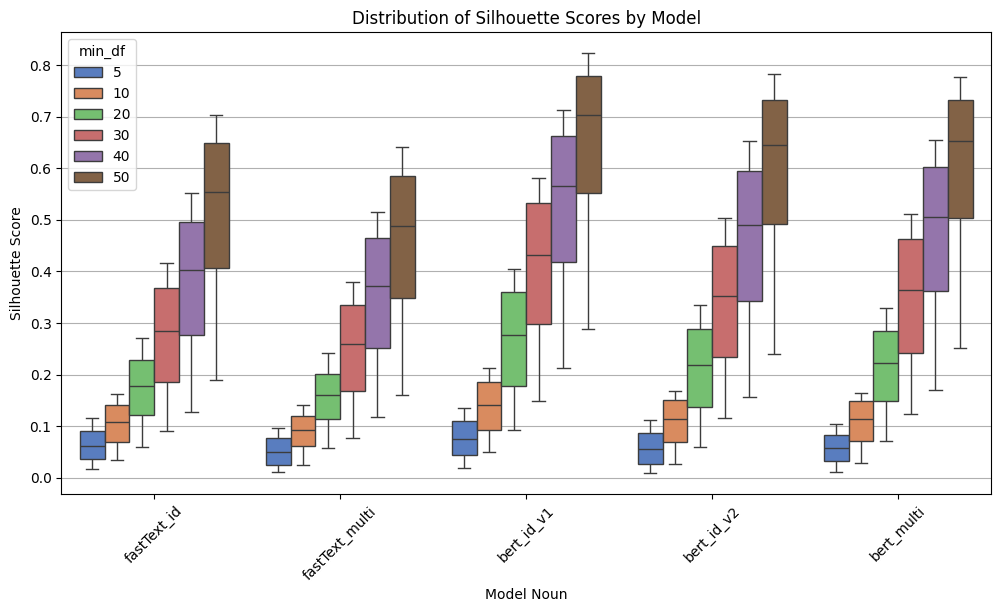

In [41]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='min_df'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


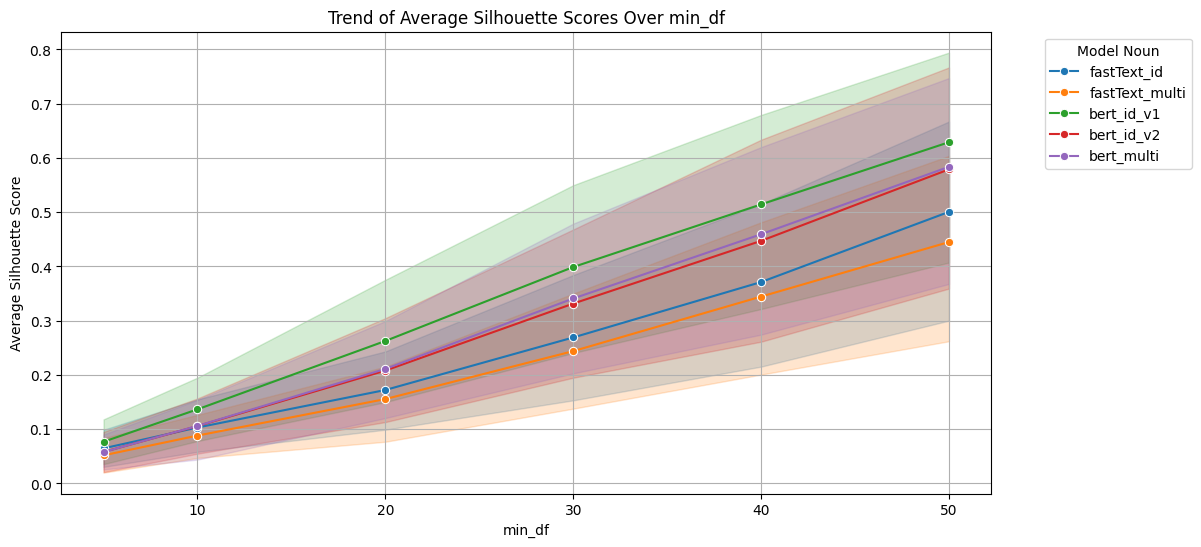

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='min_df',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over min_df")
plt.xlabel("min_df")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


In [29]:
results_df.head()

,model_noun,min_df,cluster_range,avg_silhouette_score
0,fastText_id,5,2-19,0.017414
1,fastText_id,5,100-119,0.042936
2,fastText_id,5,500-519,0.081774
3,fastText_id,5,1000-1019,0.115430
4,fastText_multi,5,2-19,0.010203


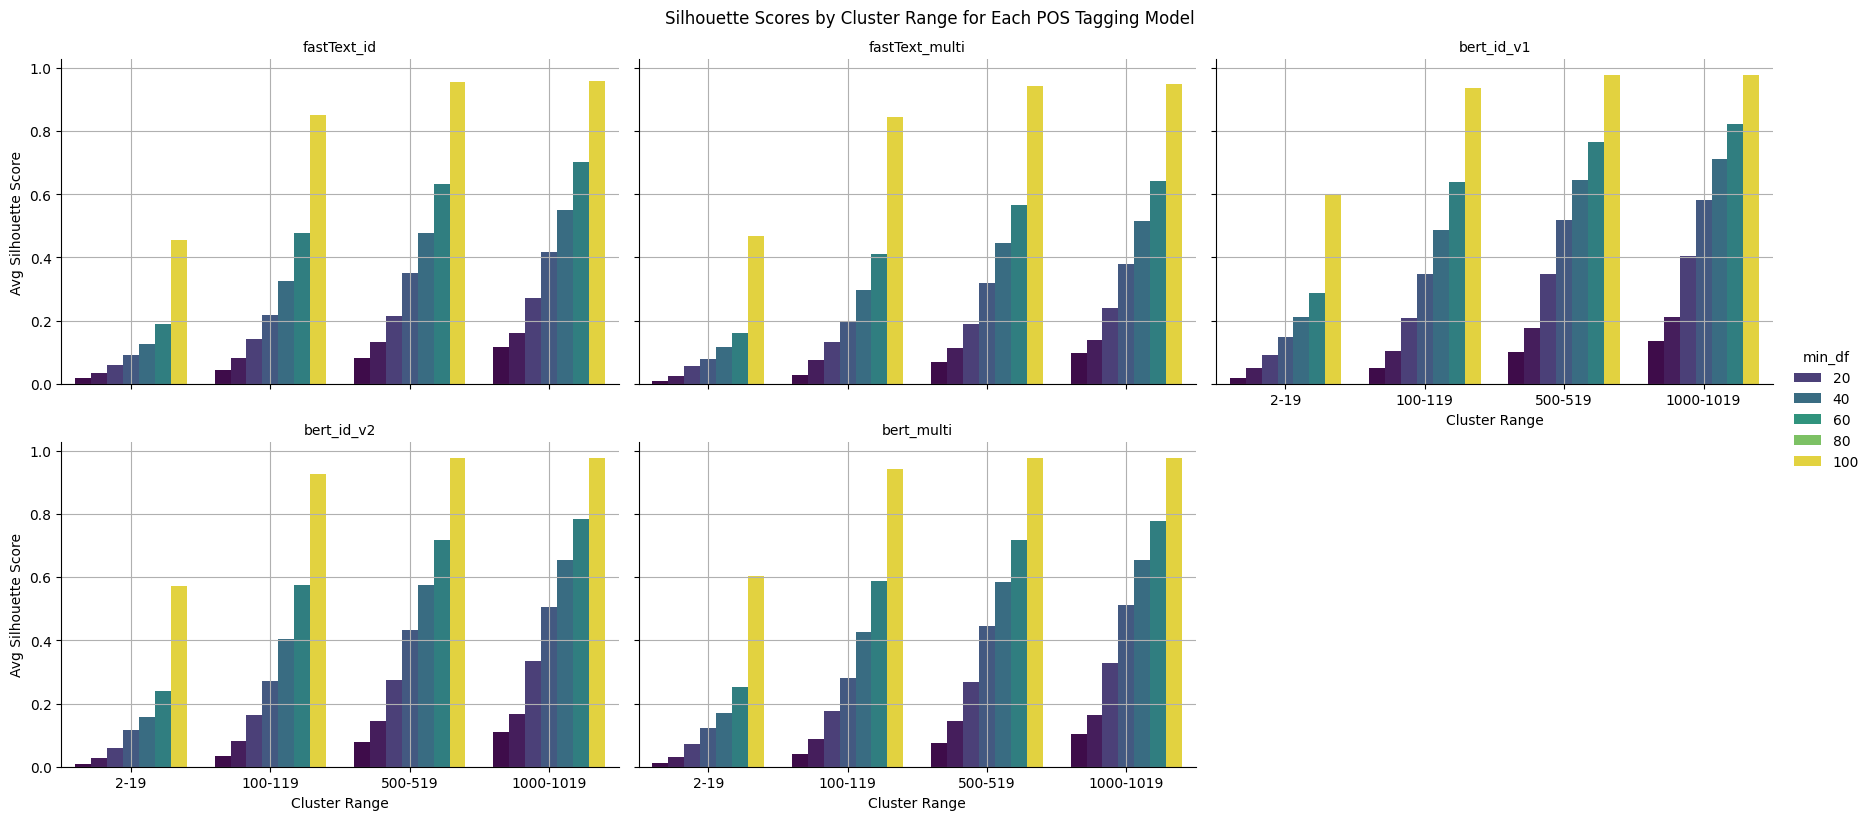

In [69]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="min_df")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
g.add_legend(title="min_df")
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

In [62]:
X_en_noun = TfidfVectorizer(max_df=0.95, min_df=50, stop_words='english').fit_transform(df['multiCorpus_noun'])

K=2, Silhouette Score=0.1957624972795295
K=3, Silhouette Score=0.19858136203110027
K=4, Silhouette Score=0.20852495813038094
K=5, Silhouette Score=0.25324195378572495
K=6, Silhouette Score=0.2660020720997991
K=7, Silhouette Score=0.27398994081061884
K=8, Silhouette Score=0.27732106523555816
K=9, Silhouette Score=0.28511171706459654
K=10, Silhouette Score=0.29281353368708146
K=11, Silhouette Score=0.29840092189245426
K=12, Silhouette Score=0.30852723295590356
K=13, Silhouette Score=0.3114299443188261
K=14, Silhouette Score=0.3170186996473034
K=15, Silhouette Score=0.3255291037369252
K=16, Silhouette Score=0.32921937315389177
K=17, Silhouette Score=0.3417663289880955
K=18, Silhouette Score=0.3449275018075216
K=19, Silhouette Score=0.34906981453550595


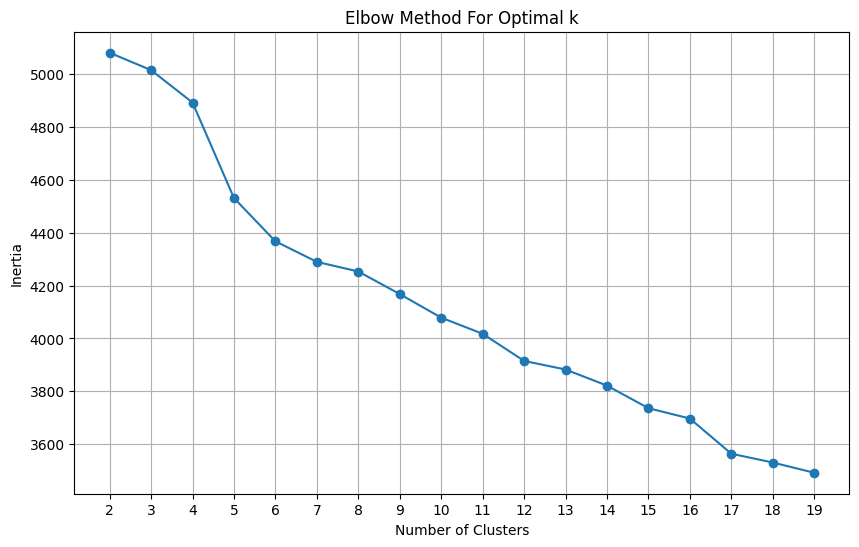

In [63]:
inertia_values = []
cluster_range = range(2, 20)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_en_noun)
    inertia_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_en_noun, labels)
    print(f"K={n_clusters}, Silhouette Score={sil_score}")

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [67]:
optimal_k = 17
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_en_noun)

In [68]:
pd.set_option('display.max_colwidth', None)

# Show some product examples from each cluster
for n_clusters in range(optimal_k):
    print(f"\nExamples of products in Cluster {n_clusters}:")
    print(df[df['cluster'] == n_clusters][['name']].head(5))

# Reset display option
pd.reset_option('display.max_colwidth')


Examples of products in Cluster 0:
                                                             name
0                Gamis Pria Dewasa Premium / Jubah Pakistan Polos
1        Buket Bunga Mawar Flanel / Bunga wisuda / Bunga souvenir
5  SUAVECITO wax rambut warna abu abu grey silver pomade gel clay
6                   Celana Renang Pria Dewasa Panjang hitam Polos
7                                Rexus Gaming Chair Kursi RGC-R60

Examples of products in Cluster 1:
                                                                       name
88                   Alat Pemadam Api Mobil Mini APAR Ringan Portable 500ml
96                 Alat Pembuat Kerucut Cone Es Krim Ice Cone Maker Sonifer
99   GELAS UKUR 15 ML ALAT PENAKAR TAKAR OBAT CAIRAN PENGUKUR TAKARAN KECIL
100    Alat Jepit Tuner Stem Setel Gitar Guitar Bas Bass Ukulele Biola JOYO
183                    Alat Pengukur Tegangan Listrik Voltmeter Display LED

Examples of products in Cluster 2:
                                        